In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../../../")
import utils
from sklearn.decomposition import PCA
import umap
import graph
import visualize
import sklearn.metrics

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read in files
snap_embed = np.load('../data/469_double_snap_combo_stable_0325.npy')
features = np.load('../data/469_pc.npy')[:,:30]
concact_embed = np.load("../data/469_concact.npy")
spice_embed = np.load("../data/spicemix_469_embedding.npy")

##### load in muse 0-4 batch results
muse_embed0 = np.load("../data/muse_469_embedding_batch_0.npy")
muse_embed1 = np.load("../data/muse_469_embedding_batch_1.npy")
muse_embed2 = np.load("../data/muse_469_embedding_batch_2.npy")
muse_embed3 = np.load("../data/muse_469_embedding_batch_3.npy")
muse_embed4 = np.load("../data/muse_469_embedding_batch_4.npy")
muse_embedll = [muse_embed0, muse_embed1, muse_embed2, muse_embed3, muse_embed4]

print([snap_embed.shape, features.shape, concact_embed.shape,
      spice_embed.shape, muse_embed0.shape])

[(54867, 32), (54867, 30), (54867, 41), (54867, 30), (10000, 30)]


In [3]:
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(snap_embed.shape[0], 10000, replace=False)
    
    snap_embed_sub = snap_embed[indices]
    features_sub = features[indices]
    concact_embed_sub = concact_embed[indices]
    spice_embed_sub = spice_embed[indices]
    muse_embed_sub = muse_embedll[i]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    feature_ss_list = []
    snap_ss_list = []
    concact_ss_list = []
    spice_ss_list = []
    muse_ss_list = []
    k_clusters = [x for x in range(5,30,2)]

    for k in k_clusters:

        ## feature
        feature_edges = graph.get_feature_edges(
            arr=features_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        feature_labels = graph.graph_clustering(
            features_sub.shape[0], feature_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## snap
        snap_edges = graph.get_feature_edges(
            arr=snap_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        snap_labels = graph.graph_clustering(
            snap_embed_sub.shape[0], snap_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        ## concact 
        concact_edges = graph.get_feature_edges(
            arr=concact_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        concact_labels = graph.graph_clustering(
            concact_embed_sub.shape[0], concact_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        
        ## muse 
        muse_edges = graph.get_feature_edges(
            arr=muse_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        muse_labels = graph.graph_clustering(
            muse_embed_sub.shape[0], muse_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        
        ## spice 
        spice_edges = graph.get_feature_edges(
            arr=spice_embed_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        spice_labels = graph.graph_clustering(
            spice_embed_sub.shape[0], spice_edges, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )

        feature_ss = sklearn.metrics.calinski_harabasz_score(features_sub, feature_labels)
        snap_ss = sklearn.metrics.calinski_harabasz_score(snap_embed_sub, snap_labels)
        concact_ss = sklearn.metrics.calinski_harabasz_score(concact_embed_sub, concact_labels)
        spice_ss = sklearn.metrics.calinski_harabasz_score(spice_embed_sub, spice_labels)
        muse_ss = sklearn.metrics.calinski_harabasz_score(muse_embed_sub, muse_labels)

        feature_ss_list.append(feature_ss)
        snap_ss_list.append(snap_ss)
        concact_ss_list.append(concact_ss)
        spice_ss_list.append(spice_ss)
        muse_ss_list.append(muse_ss)
        
    data = {'k':k_clusters, 'ch_feature':feature_ss_list,
            'ch_snap':snap_ss_list,'ch_concact':concact_ss_list,
           'ch_spice':spice_ss_list, 'ch_muse':muse_ss_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    


at 0
at 1
at 2
at 3
at 4


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


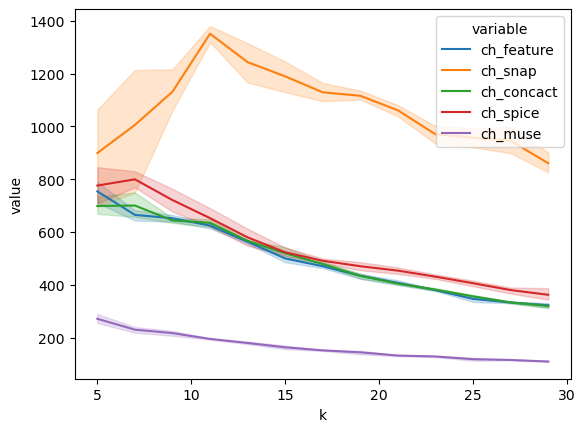

In [4]:
test = pd.concat(dflist)
test2 = test.melt(id_vars=['k'], value_vars=['ch_feature', 'ch_snap', 'ch_concact', 'ch_spice', 'ch_muse'])
test2.to_csv('../data/CH_result_liv_0325.csv')

plot = sns.lineplot(data=test2,x="k", y="value", hue="variable")
fig = plot.get_figure()
#fig.savefig('../plots/CH_allmethods_dbGNNstab.svg', dpi = 300) 